In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    pairwise_distances, adjusted_rand_score,
    silhouette_score, davies_bouldin_score
)
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import MinMaxScaler

In [2]:
FIG_DIR = Path() / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def dbscan_n_clust(e, m, df):
    db = DBSCAN(eps=e, min_samples=m)
    pred = db.fit_predict(df)
    clusters_found = len(np.unique(pred))
    return clusters_found

def dbscan_score(e, m, df):
    db = DBSCAN(eps=e, min_samples=m)
    pred = db.fit_predict(df)
    score = np.nan
    # Only compute silhouette if there's more than 1 cluster
    if len(np.unique(pred)) > 1:
        score = silhouette_score(df, pred)
    return score

def entropy(cluster_assignment, y_true):
    """
    Computes a simple entropy measure of how well each true label
    is 'pure' within the predicted clusters. 
    """
    df = (
        pd.DataFrame([cluster_assignment, y_true], index=["cluster", "label"])
        .T
    )
    
    def group_entropy(s):
        e = s.value_counts(normalize=True)
        e *= np.log2(e)
        return -e.sum()
    
    group_stats = (
        df
        .groupby("label")["cluster"]
        .agg([group_entropy, "count"])
    )
    # Weighted sum of entropies
    ew = (group_stats.prod(axis=1).sum()) / len(y_true)
    return ew

In [4]:
def agg_eval(e, m, y_true, df):
    """
    Runs DBSCAN on df with (eps=e, min_samples=m),
    returns a tuple:
      (clusters_found, contains_noise, silhouette_score, ARS, davies_bouldin_score)
      
    Note: Davies-Bouldin (DB) is a compactness/separation metric where a lower score is better.
    """
    db = DBSCAN(eps=e, min_samples=m)
    db.fit(df)
    unique_labels = np.unique(db.labels_)
    clusters_found = len(unique_labels)
    contains_noise = (-1 in unique_labels)
    
    y_pred = db.labels_[:len(y_true)]
    
    ss = np.nan
    db_score = np.nan
    if len(unique_labels) > 1:
        ss = silhouette_score(df, y_pred)
        db_score = davies_bouldin_score(df, y_pred)
    
    ars = adjusted_rand_score(y_true, y_pred)
    
    return clusters_found, contains_noise, ss, ars, db_score

vec_agg_eval = np.vectorize(agg_eval, excluded={2, 3})

In [5]:
def visualize_dbscan_results(
        df, y_true, eps=None, mins=None, dataset_name=None, marker_offset=0.1
        ): 
    """
    Visualizes DBSCAN performance across a grid of (eps, min_samples) values.

    The function creates a 3x3 grid of subplots:
      - Top row:
          (a) Scatter plot of the raw data.
          (b) Histogram (with KDE) of the nearest-neighbor distances.
          (c) Heatmap showing the number of clusters detected.
      - Middle row:
          (d) Heatmap of Davies-Bouldin scores (lower is better).
          (e) Heatmap of Silhouette scores (higher is better; range: [-1,1]).
          (f) Heatmap of Adjusted Rand Scores (higher is better; typical range: [-0.5,1]).
      - Bottom row:
          (g, h, i) Scatter plots of the data colored by the DBSCAN clustering that achieved the best 
          performance for Davies-Bouldin, Silhouette, and ARS respectively.
          These are determined by marking the cell with the minimum Davies-Bouldin score and the maximum 
          Silhouette and ARS scores from the heatmaps in the middle row.

    Markers are overlaid on the heatmaps to indicate cells with:
      - "Noise" (presence of noise in DBSCAN labels),
      - The best (i.e. min or max) score for each metric.

    Parameters
    ----------
    df : array-like of shape (n_samples, n_features)
        The input data to cluster.
    y_true : array-like of shape (n_samples,)
        True labels used for evaluation (e.g., to compute Adjusted Rand Score).
    eps : array-like, optional
        Range of eps values to explore. Defaults to np.arange(3, 5.5, 0.5).
    mins : array-like, optional
        Range of min_samples values to explore. Defaults to np.logspace(2, 6, 5, base=2, dtype=int).
    dataset_name : str, optional
        An optional name for the dataset. If provided, it is included in the overall figure title.
    marker_offset : float, optional
        Offset used when plotting markers on the heatmaps (to avoid overlap with annotations).

    Returns
    -------
    dbs_df, scores_df, ars_df : tuple of pandas.DataFrame
        DataFrames containing the Davies-Bouldin scores, Silhouette scores, and Adjusted Rand Scores,
        respectively, across the grid of (eps, min_samples) values.
    """
    if eps is None:
        eps = np.arange(3, 5.5, 0.5)
    if mins is None:
        mins = np.logspace(2, 6, 5, base=2, dtype=int)
    
    eps_grid, mins_grid = np.meshgrid(eps, mins)
    
    n_clusts_, noise_, scores_, ars_, dbs_ = vec_agg_eval(eps_grid, mins_grid, y_true, df)
    
    eps_labels = pd.Series(eps, name="eps").round(2)
    idx_mins = pd.Series(mins, name="min_samples")
    
    n_clusts_df = pd.DataFrame(n_clusts_, index=idx_mins, columns=eps_labels)
    scores_df = pd.DataFrame(scores_, index=idx_mins, columns=eps_labels)
    ars_df = pd.DataFrame(ars_, index=idx_mins, columns=eps_labels)
    dbs_df = pd.DataFrame(dbs_, index=idx_mins, columns=eps_labels)
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
    plt.tight_layout()

    def despine(ax):
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    
    # Top row: Scatter, histogram, #clusters heatmap
    sns.scatterplot(x=df[:, 0], y=df[:, 1], ax=axes[0, 0], color="steelblue")
    despine(axes[0, 0])
    axes[0, 0].axis("equal")
    axes[0, 0].set_xlabel("Feature 1")
    axes[0, 0].set_ylabel("Feature 2")
    axes[0, 0].set_title("Raw Data", size="medium")

    all_distances = pairwise_distances(df)
    all_distances_temp = all_distances.copy()
    n_ = len(all_distances_temp)
    all_distances_temp[np.diag_indices(n_)] = all_distances_temp.max() + 1e6
    neig_distances = np.min(all_distances_temp, axis=1)
    
    sns.histplot(
        neig_distances, ax=axes[0, 1], kde=True, color="steelblue",
        bins=25, binrange=(0, .25),
    )
    axes[0, 1].text(
        0.95, 0.95,
        "\n".join(str(pd.Series(neig_distances).describe().round(4)).split("\n")[1:-1]),
        transform=axes[0, 1].transAxes, ha="right", va="top"
    )
    despine(axes[0, 1])
    axes[0, 1].set_xlabel("Distance to Closest Neighbor")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].set_title("NND Histogram", size="medium")
    
    sns.heatmap(
        n_clusts_df, ax=axes[0, 2], annot=True, fmt="d", 
        cmap="crest", cbar_kws={"location": "top", "label": "# of Clusters"}
    )

    # Bottom row: DB, Silhouette, ARS
    sns.heatmap(
        dbs_df, ax=axes[1, 0], annot=True, fmt=".2f",
        cmap="flare", vmin=0,
        cbar_kws={"location": "top", "label": "Davies-Bouldin Score"},
        annot_kws={"fontsize":"small"}
    )
    sns.heatmap(
        scores_df, ax=axes[1, 1], annot=True, fmt=".2f",
        cmap="Spectral", vmin=-1, vmax=1,
        cbar_kws={"location": "top", "label": "Silhouette Score"},
        annot_kws={"fontsize":"small"}
    )
    sns.heatmap(
        ars_df, ax=axes[1, 2], annot=True, fmt=".2f",
        cmap="icefire", vmin=-0.5, vmax=1,
        cbar_kws={"location": "top", "label": "Adjusted Rand Score"},
        annot_kws={"fontsize":"small"}
    )
    
    def plot_max_point(arr, ax, offset=marker_offset):
        """
        Find the cell with the maximum value in 'arr' (ignoring NaN),
        and place a 'X' marker.
        """
        max_idx = np.nanargmax(arr)
        iy, ix = np.unravel_index(max_idx, arr.shape)
        ax.plot(ix + offset, iy + offset, "X", color="red", label="Max")
        ax.legend(
            loc="right", bbox_to_anchor=(1.05, 1.25),
            handletextpad=0.1, frameon=False
            )
        return ix, iy

    def plot_min_point(arr, ax, offset=marker_offset):
        """
        Find the cell with the minimum value in 'arr' (ignoring NaN),
        and place a 'X' marker.
        
        Davies-Bouldin is lower-is-better, so we highlight the min cell.
        """
        min_idx = np.nanargmin(arr)
        iy, ix = np.unravel_index(min_idx, arr.shape)
        ax.plot(ix + offset, iy + offset, "X", color="blue", label="Min")
        ax.legend(
            loc="right", bbox_to_anchor=(1.05, 1.25),
            handletextpad=0.1, frameon=False
            )
        return ix, iy
    
    def plot_noise_flag(noise_arr, ax, offset=marker_offset):
        """
        For any True cell in noise_arr, place a '.' marker,
        indicating presence of noise in DBSCAN labels.
        """
        rows, cols = np.where(noise_arr)
        ax.plot(cols + offset, rows + offset, ".", color="k", label="Noise")
        if len(rows) > 0:
            ax.legend(
                loc="right", bbox_to_anchor=(1.05, 1.25),
                bbox_transform=ax.transAxes,
                handletextpad=0.1, frameon=False
            )
    
    def plot_best(idx, idy, ax, plot_ylabel=False):
        best_e = float(eps_grid[idy, idx])
        best_m = int(mins_grid[idy, idx])

        db = DBSCAN(eps=round(best_e, 2), min_samples=best_m)
        pred = db.fit_predict(df)
        
        despine(ax)
        ax.axis("equal")
        ax.set_xlabel("Feature 1")
        if plot_ylabel:
            ax.set_ylabel("Feature 2")
        ax.set_title(db)

        sns.scatterplot(
            x=df[:, 0], y=df[:, 1], ax=ax,
            hue=pred, style=pred, palette="rainbow", legend=False
            )
    
    # Mark noise
    plot_noise_flag(noise_, axes[0, 2])
    # Mark best (lowest) Davies-Bouldin
    best_dbs_idx, best_dbs_idy = plot_min_point(dbs_, axes[1, 0])
    # Mark best silhouette (max)
    best_ss_idx, best_ss_idy = plot_max_point(scores_, axes[1, 1])
    # Mark best ARS (max)
    best_ars_idx, best_ars_idy = plot_max_point(ars_, axes[1, 2])

    plot_best(best_dbs_idx, best_dbs_idy, axes[2, 0], plot_ylabel=True)
    plot_best(best_ss_idx, best_ss_idy, axes[2, 1])
    plot_best(best_ars_idx, best_ars_idy, axes[2, 2])


    for ax, label in zip(axes.flat, "abcdefghi"):
        y_ = 1.05/0.8 if (label > "b") & (label < "g") else 1.05 
        ax.text(-.05, y_, label + ")", transform=ax.transAxes)
    
    plt.subplots_adjust(hspace=.2)
    if dataset_name is None:
        fig.suptitle("DBSCAN Performance", y=1.04)
    else:
        fig.suptitle(f"DBSCAN Performance on {dataset_name}", y=1.04)

    fig.savefig(FIG_DIR / f"{dataset_name}.png", bbox_inches='tight')

    return dbs_df, scores_df, ars_df

In [6]:
def transform_2d(X, scale=(1.0, 1.0), rotate_deg=0.0):
    """
    Applies a scaling and rotation in 2D:
      - First scales each dimension by scale=(sx, sy)
      - Then rotates by rotate_deg (counterclockwise).
    """
    # 1) Scale
    X_scaled = X * np.array(scale)
    
    # 2) Rotation matrix
    theta = np.deg2rad(rotate_deg)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    
    return X_scaled @ R

In [7]:
# --- Generate toy datasets ---
X0, y0 = make_moons(n_samples=600, noise=0.1, random_state=17)

X1, y1 = make_circles(n_samples=600, noise=0.1, factor=0.3, random_state=17)

rng = np.random.default_rng(17)
X2 = rng.random((600, 2))
y2 = np.zeros(len(X2))

X3, y3 = make_blobs(n_samples=600, centers=3, random_state=17)

# Transform X3 into X4 via a custom 2x2 matrix
X4 = transform_2d(X3, scale=(4, 1), rotate_deg=45)
y4 = y3.copy()

X5, y5 = make_blobs(n_samples=600, centers=3,
                    cluster_std=[1, 2, 3], random_state=17)

Xs = [X0, X1, X2, X3, X4, X5]
ys = [y0, y1, y2, y3, y4, y5]

# Scale each dataset into the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
Xs_scaled = [scaler.fit_transform(X) for X in Xs]


In [8]:
import PIL
from urllib.request import urlopen

url = "https://media.tenor.com/P43rB4EgSacAAAAe/top-gear-jeremy-clarkson.png"
clarkson = PIL.Image.open(urlopen(url))

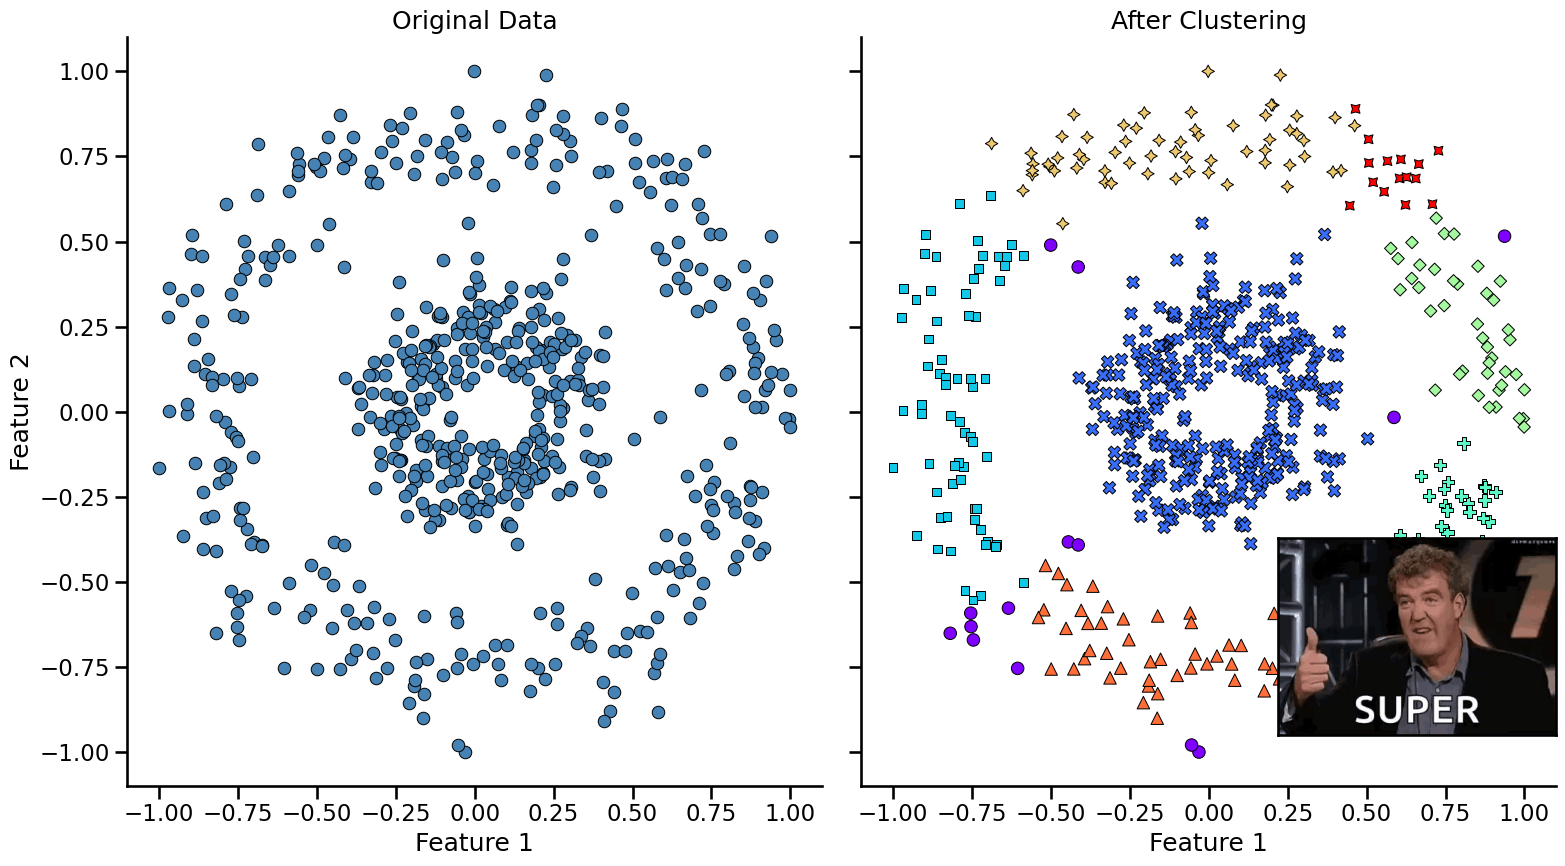

In [9]:
sns.set_context("talk")  # if only context manager worked properly...

df = pd.DataFrame(Xs_scaled[1], columns=["Feature 1", "Feature 2"])
db = DBSCAN(eps=0.18, min_samples=16)
pred = db.fit_predict(df)

fig, axes = plt.subplots(
    1, 2, figsize=(16,9), tight_layout=True, sharey=True, sharex=True
    )

def despine(ax):
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

for ax in axes: despine(ax)

sns.scatterplot(data=df, x="Feature 1", y="Feature 2", ax=axes[0], ec="k", color="steelblue")
sns.scatterplot(
    data=df, x="Feature 1", y="Feature 2", ax=axes[1], ec="k",
    hue=pred, style=pred, palette="rainbow", legend=False, 
    )
axes[0].set_title("Original Data")
axes[1].set_title("After Clustering")

axin = axes[1].inset_axes(
    bounds=(.6,0, .4, .4),
    transform=axes[1].transAxes
    )
axin.set_xticks([])
axin.set_yticks([])
axin.imshow(clarkson)
# axin.axis("image")

fig.savefig(FIG_DIR / "intro.png", bbox_inches='tight')

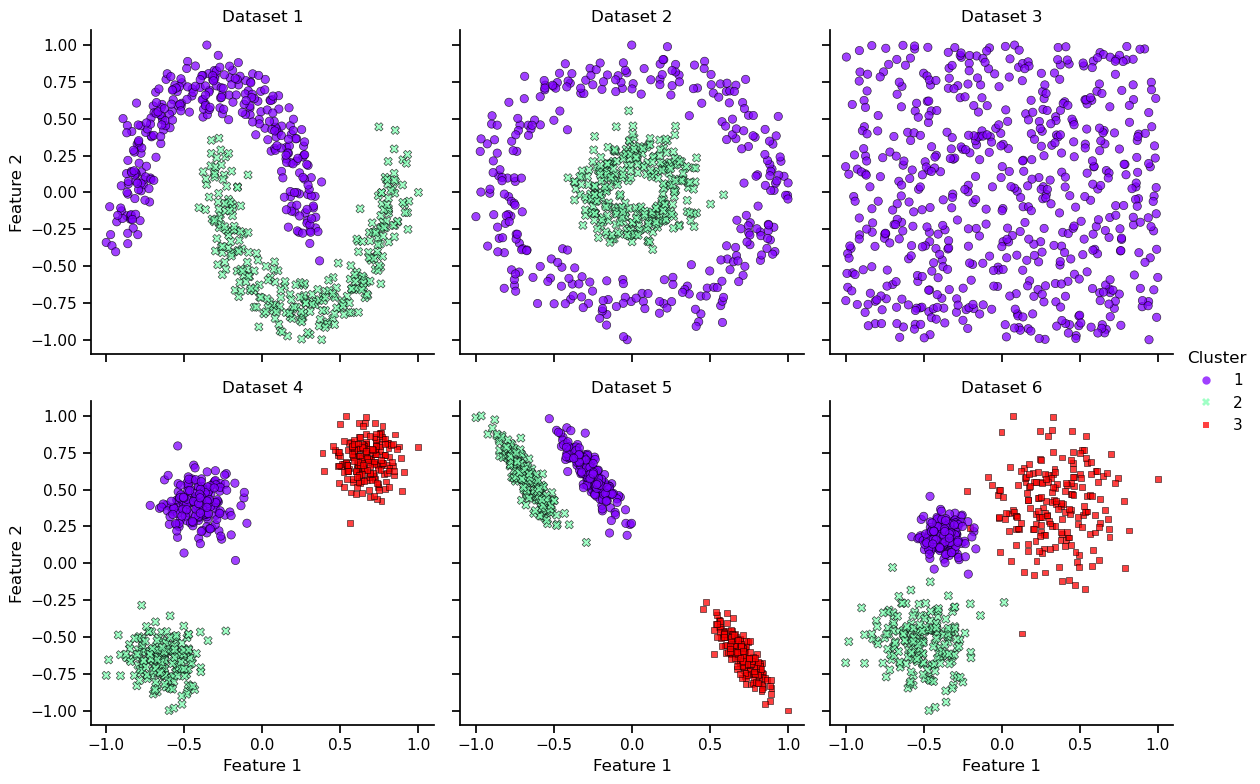

In [10]:
sns.set_context("notebook")

g = sns.relplot(
    data =(
        pd
        .DataFrame(
            data=np.vstack(Xs_scaled),
            columns=["Feature 1", "Feature 2"]
            )
        .assign(
            Cluster=np.hstack(ys).astype(int) + 1,
            Dataset=np.repeat(range(1, 7), 600)
            )
    ),
    x="Feature 1", y="Feature 2",
    col="Dataset", col_wrap=3,
    hue="Cluster", style="Cluster", palette="rainbow",
    ec="k", alpha=.75,
    height=4,
)
g.set_titles("{col_var} {col_name}");

In [11]:
# from PIL import Image
# from PyPDF2 import PdfMerger

# # List of image filenames
# images = [FIG_DIR / f"Dataset {x}.png" for x in range(1,7)]

# pdf_files = []
# for idx, img_path in enumerate(images):
#     image = Image.open(img_path)
#     pdf_path = FIG_DIR / f"temp_page_{idx}.pdf"
#     # Convert image to PDF; the page size will match the image size.
#     image.convert("RGB").save(pdf_path)
#     pdf_files.append(pdf_path)

# # Merge the individual PDF pages into one document
# merger = PdfMerger()
# for pdf in pdf_files:
#     merger.append(pdf)

# # Write out the merged PDF
# merger.write("output.pdf")
# merger.close()

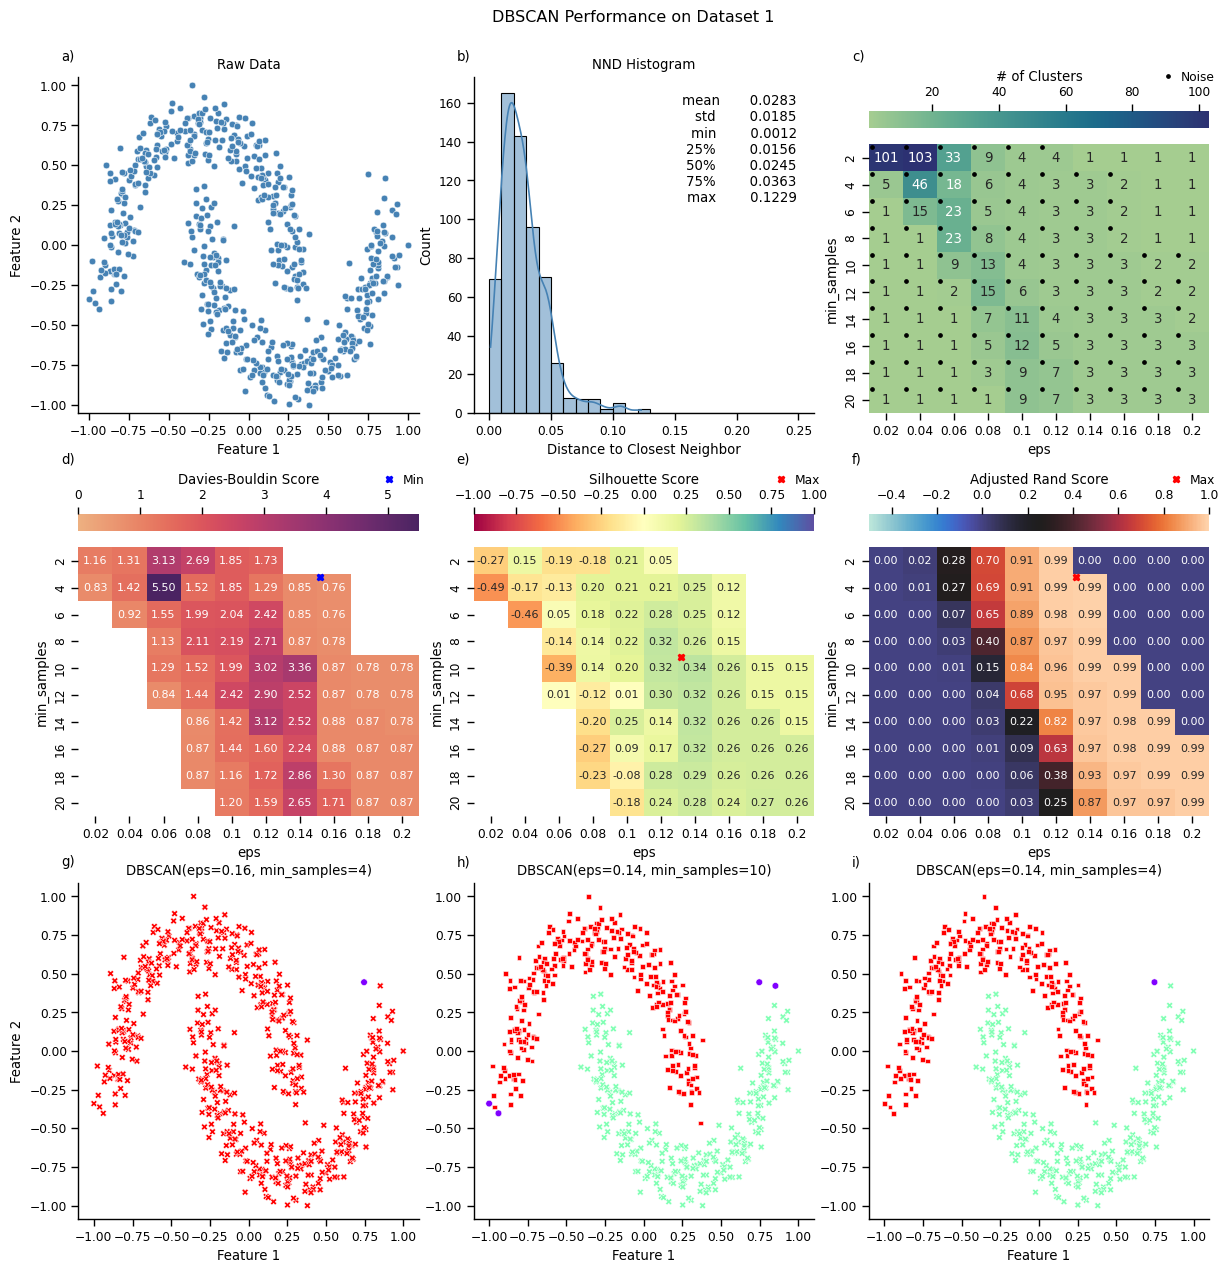

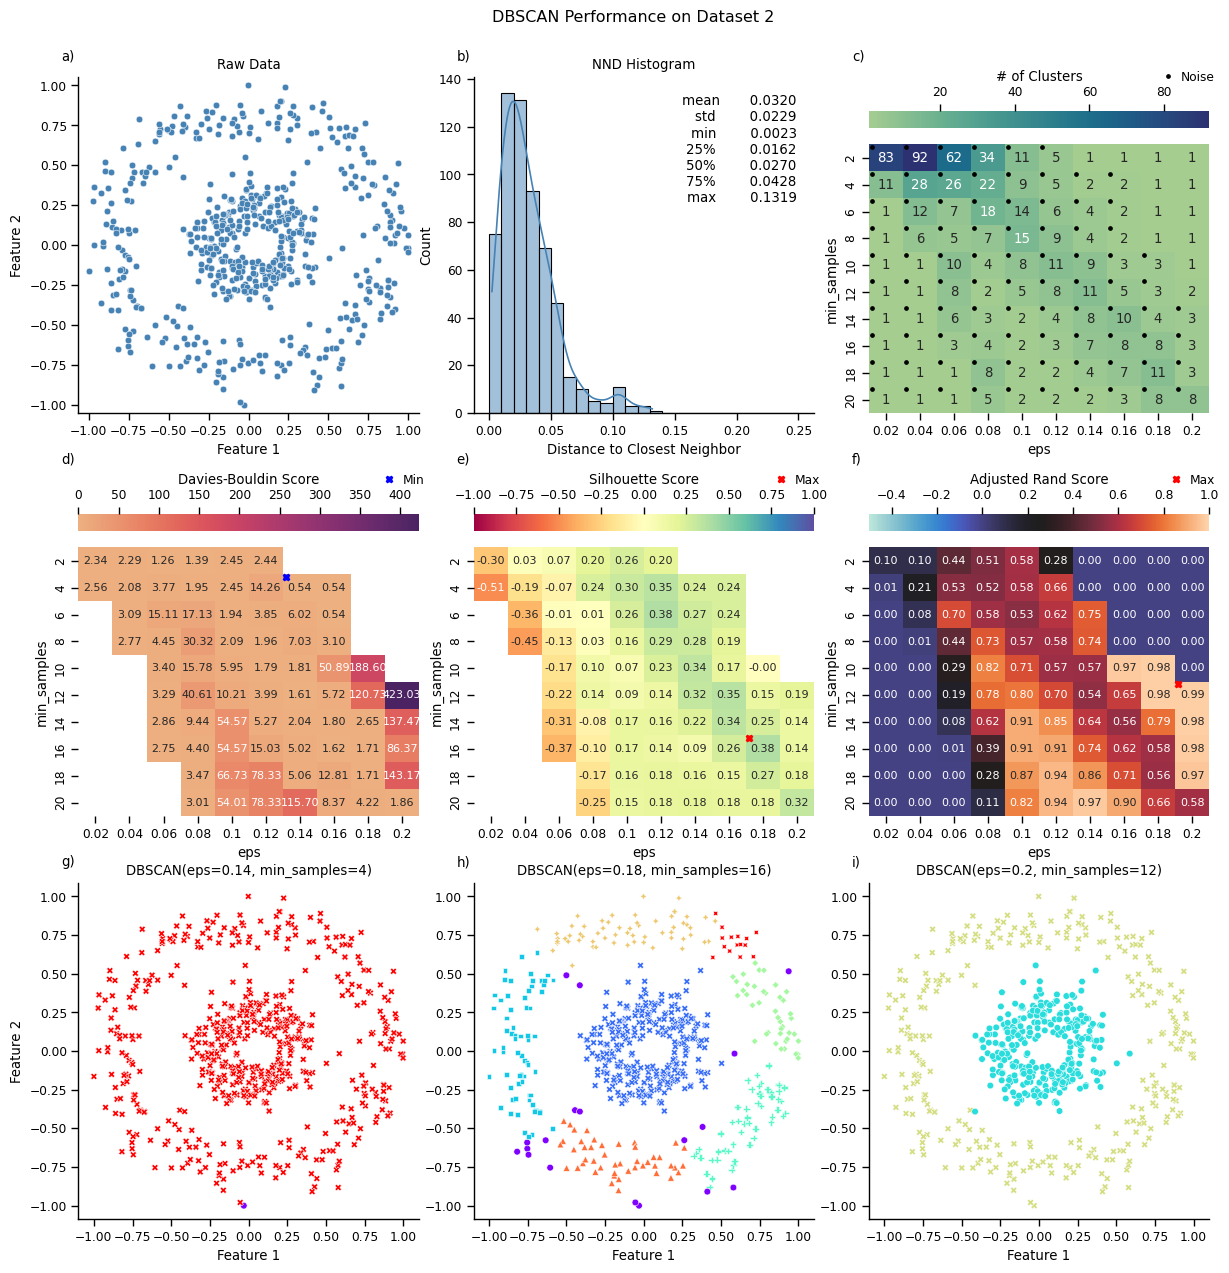

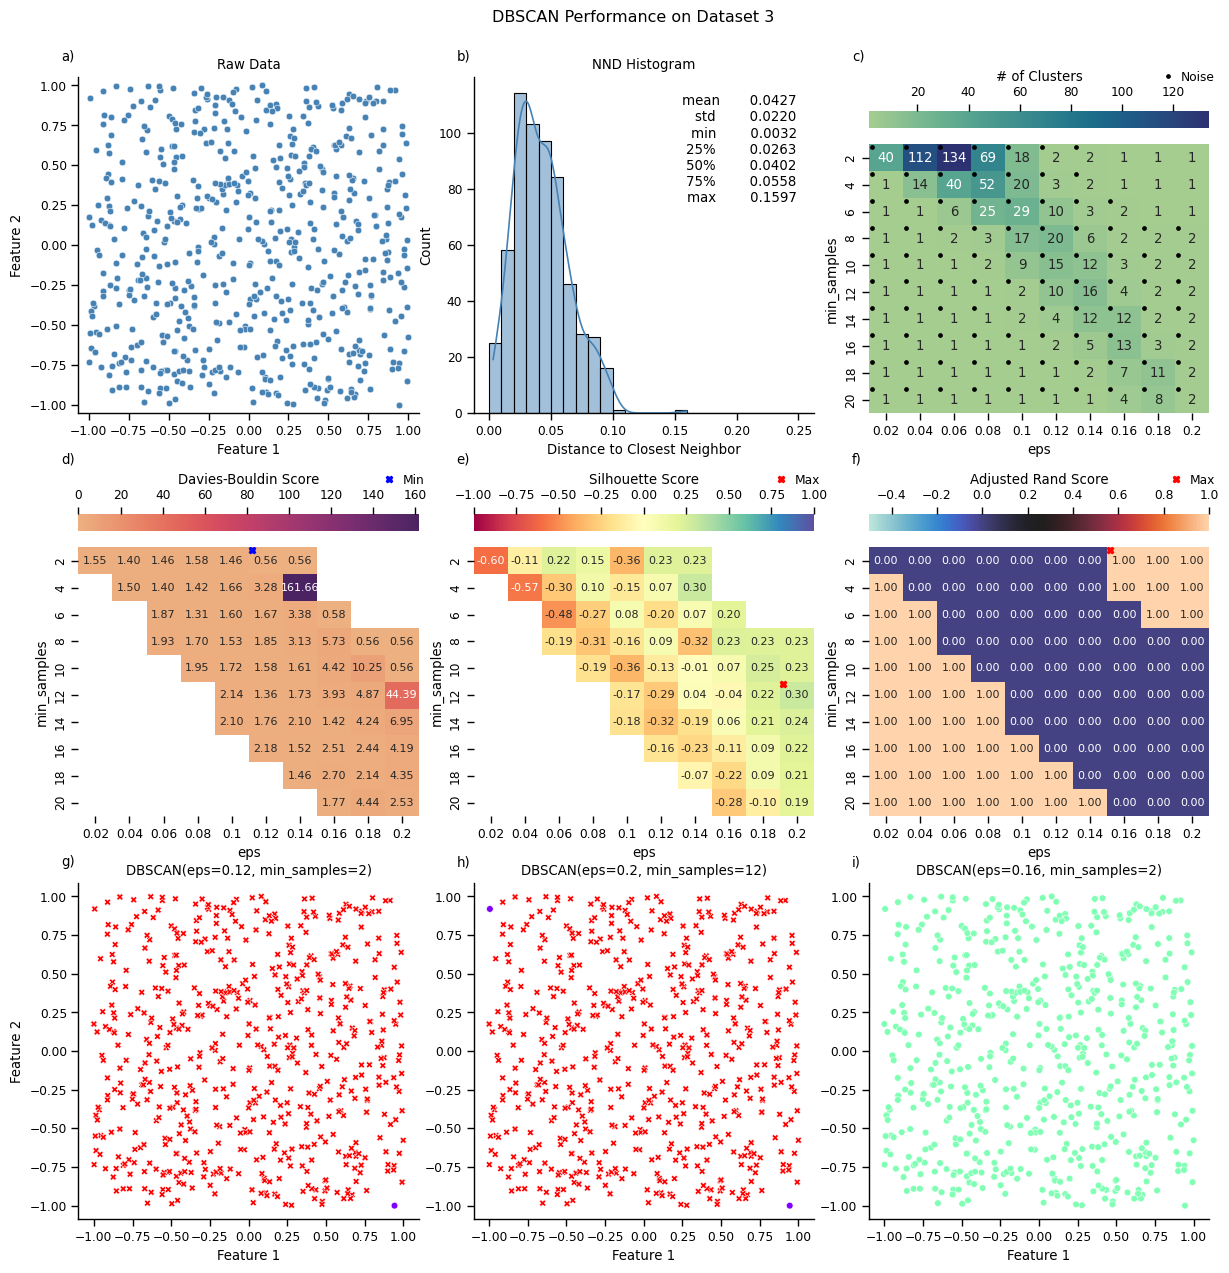

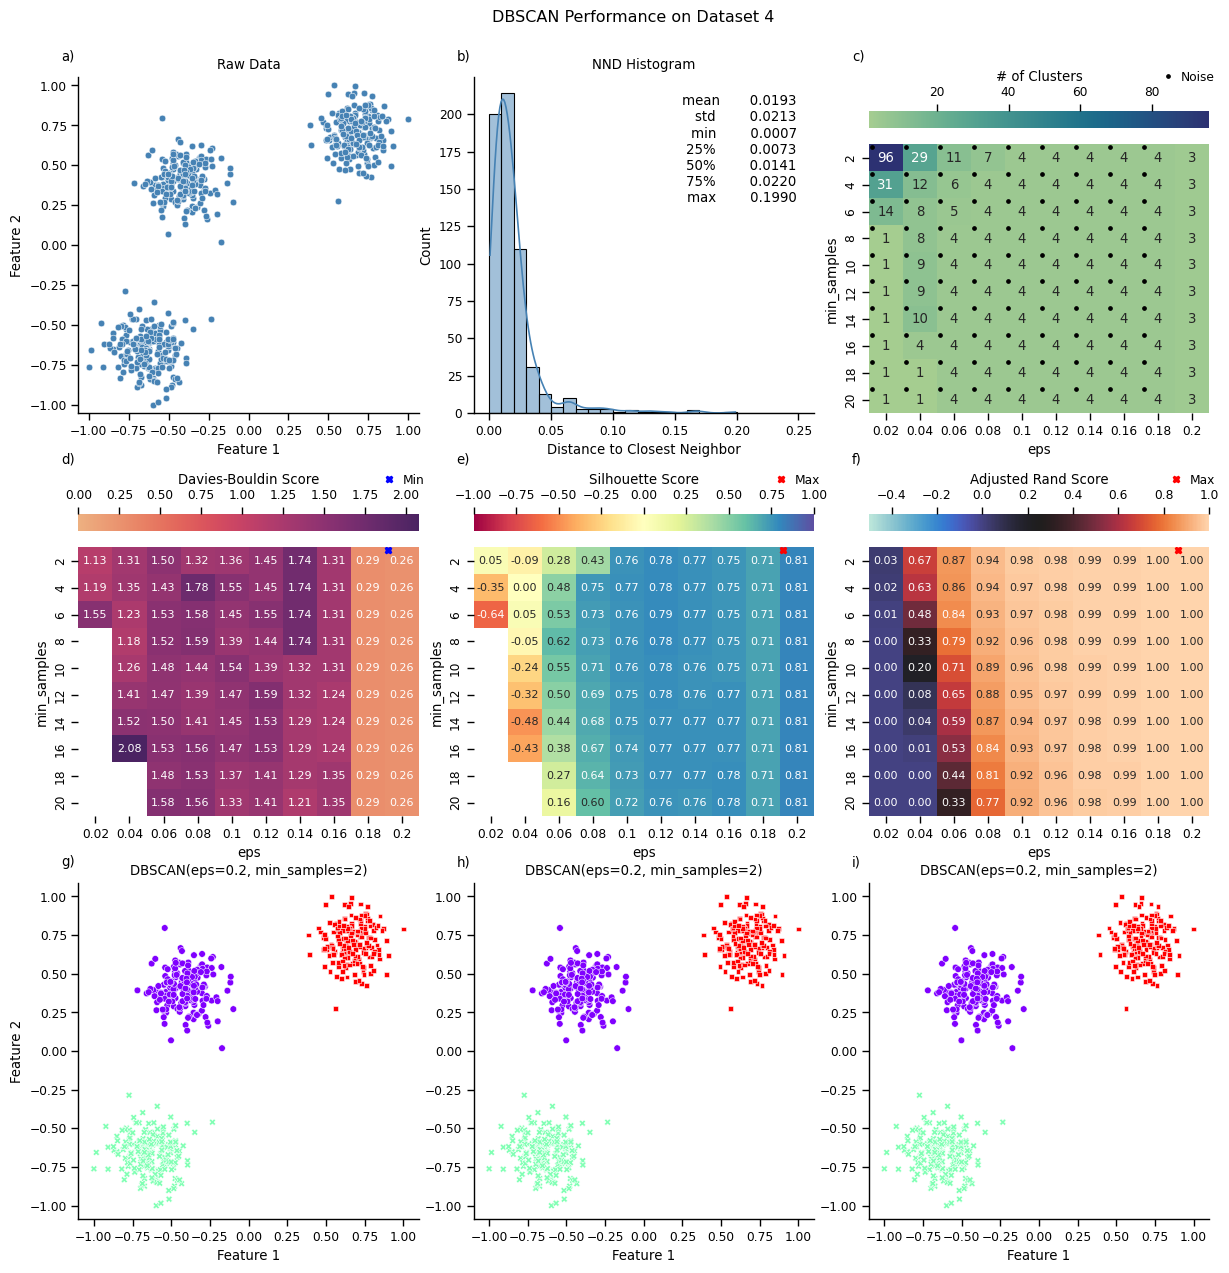

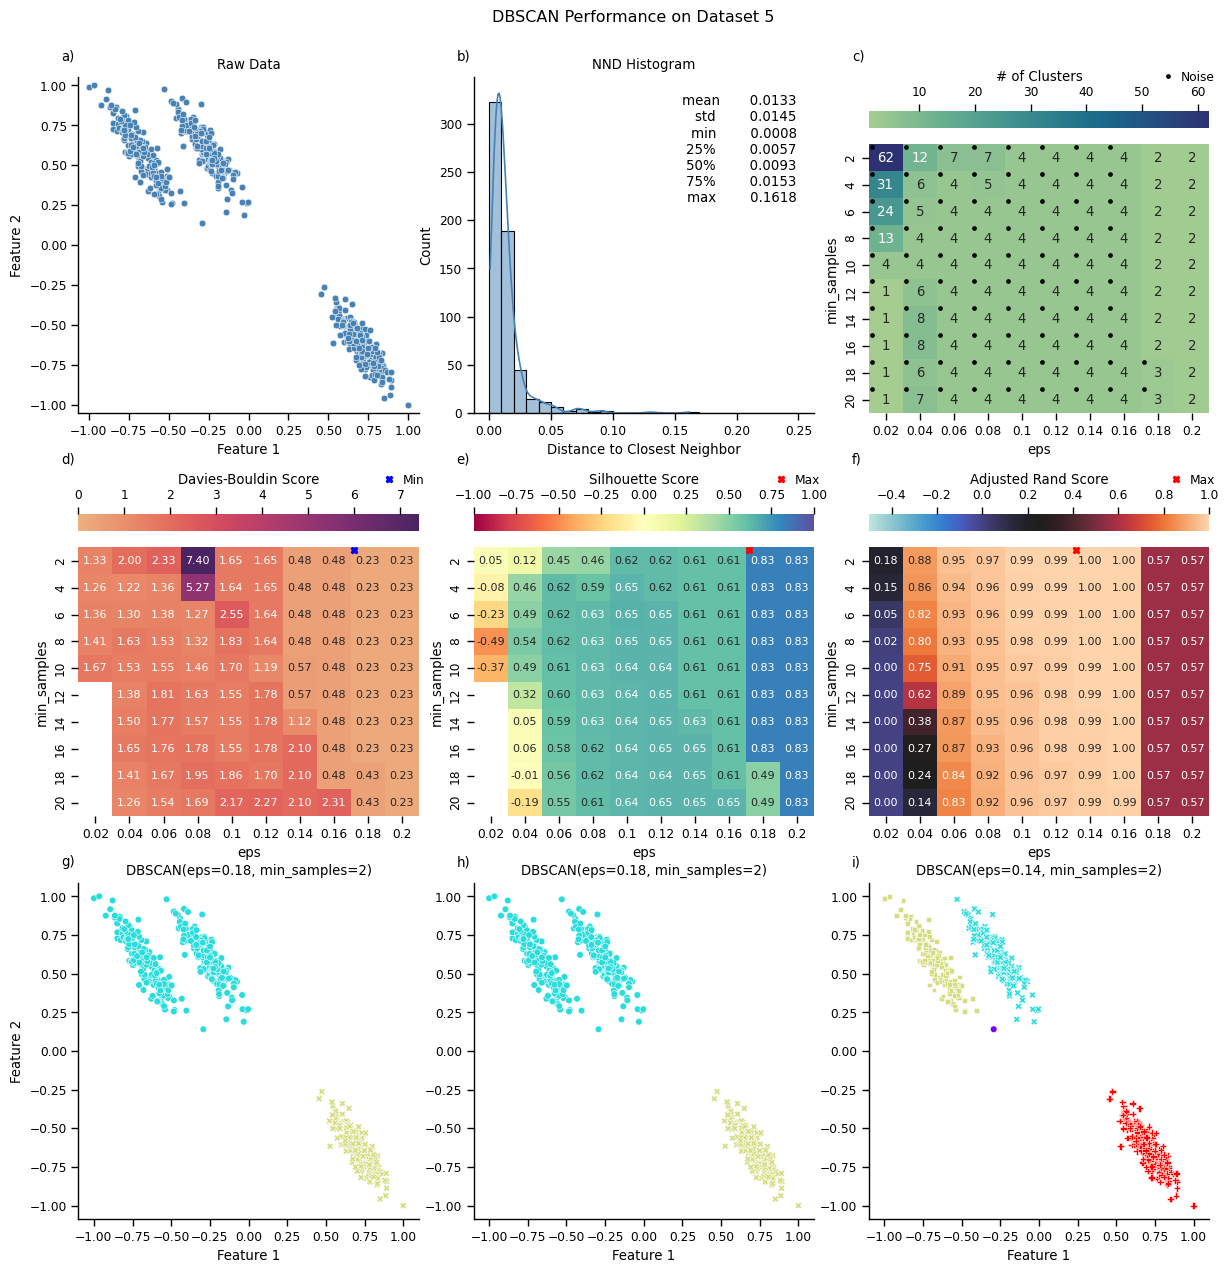

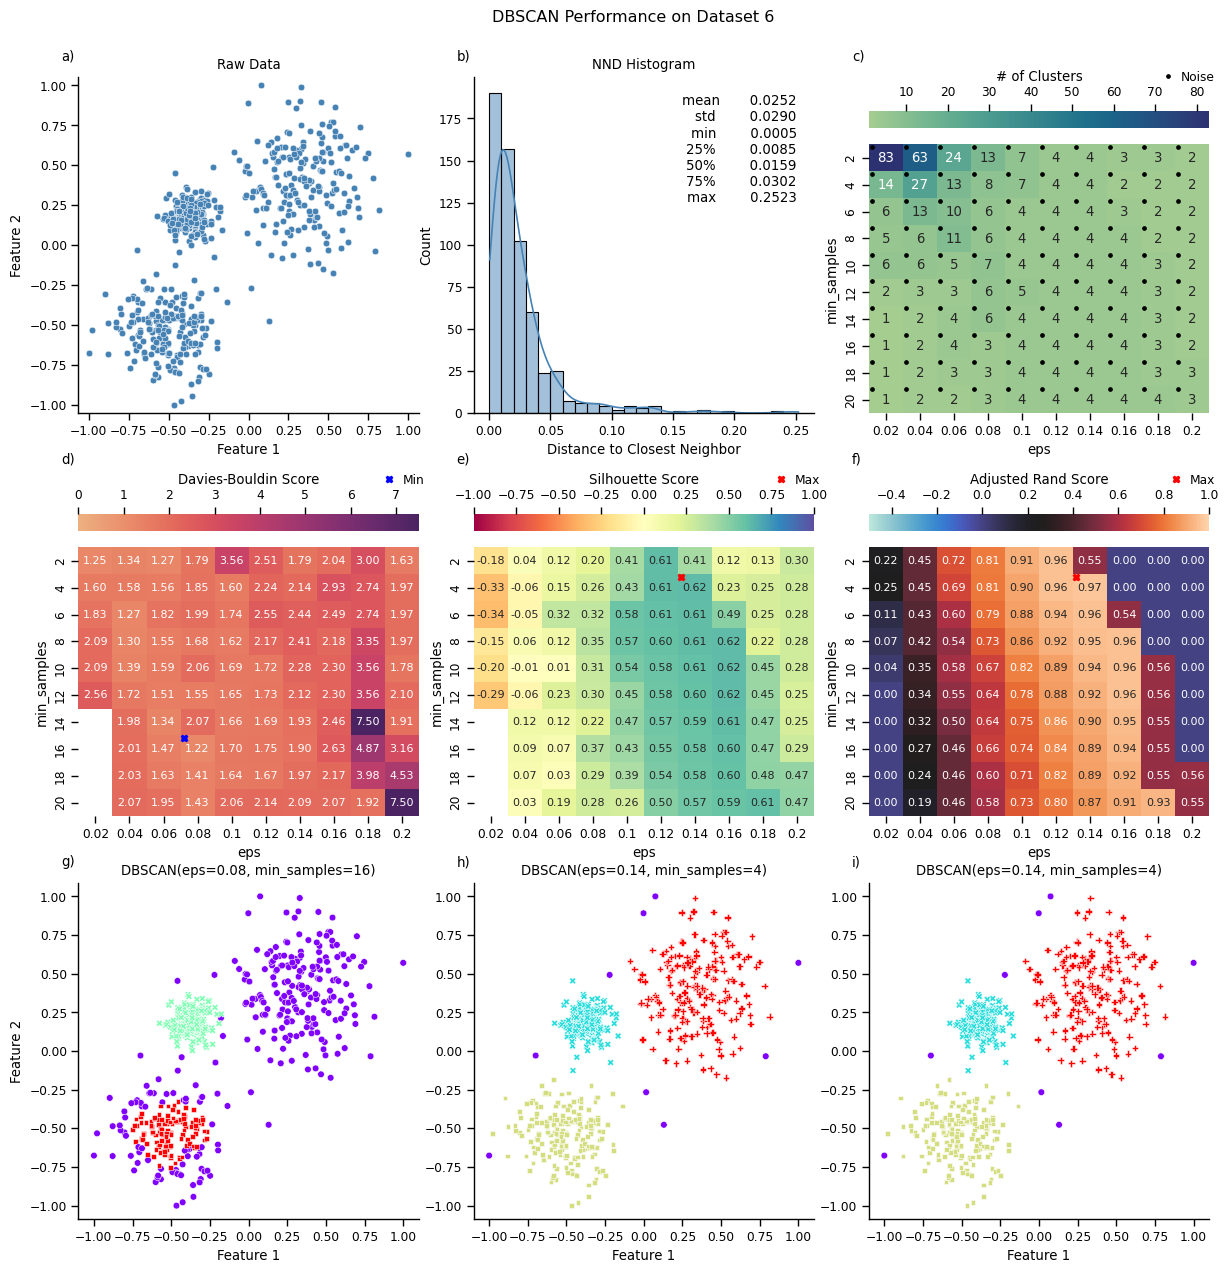

In [12]:
sns.set_context("paper")
dbs_df_log, scores_df_log, ars_df_log = [], [], []
dataset_names = [f"Dataset {x}" for x in range(1, 7)]
for X, y, name in zip(Xs_scaled, ys, dataset_names):
    dbs_df, scores_df, ars_df = visualize_dbscan_results(
        X, y,
        eps=np.arange(0.02, 0.22, 0.02),
        mins=range(2, 22, 2),
        dataset_name=name 
    )
    dbs_df_log.append(dbs_df)
    scores_df_log.append(scores_df)
    ars_df_log.append(ars_df)

In [13]:
results = pd.DataFrame(
    {
        "Dataset":np.repeat(range(1, 7), 100),
        "Adjusted Rand Score": np.hstack([df.values.ravel() for df in ars_df_log]),
        "Silhouette Score": np.hstack([df.values.ravel() for df in scores_df_log]),
        "Davies-Bouldin Score": np.hstack([df.values.ravel() for df in dbs_df_log]),
    }
)
results["Scaled Davies-Bouldin Score"] =  MinMaxScaler().fit_transform(
    results[["Davies-Bouldin Score"]]
)

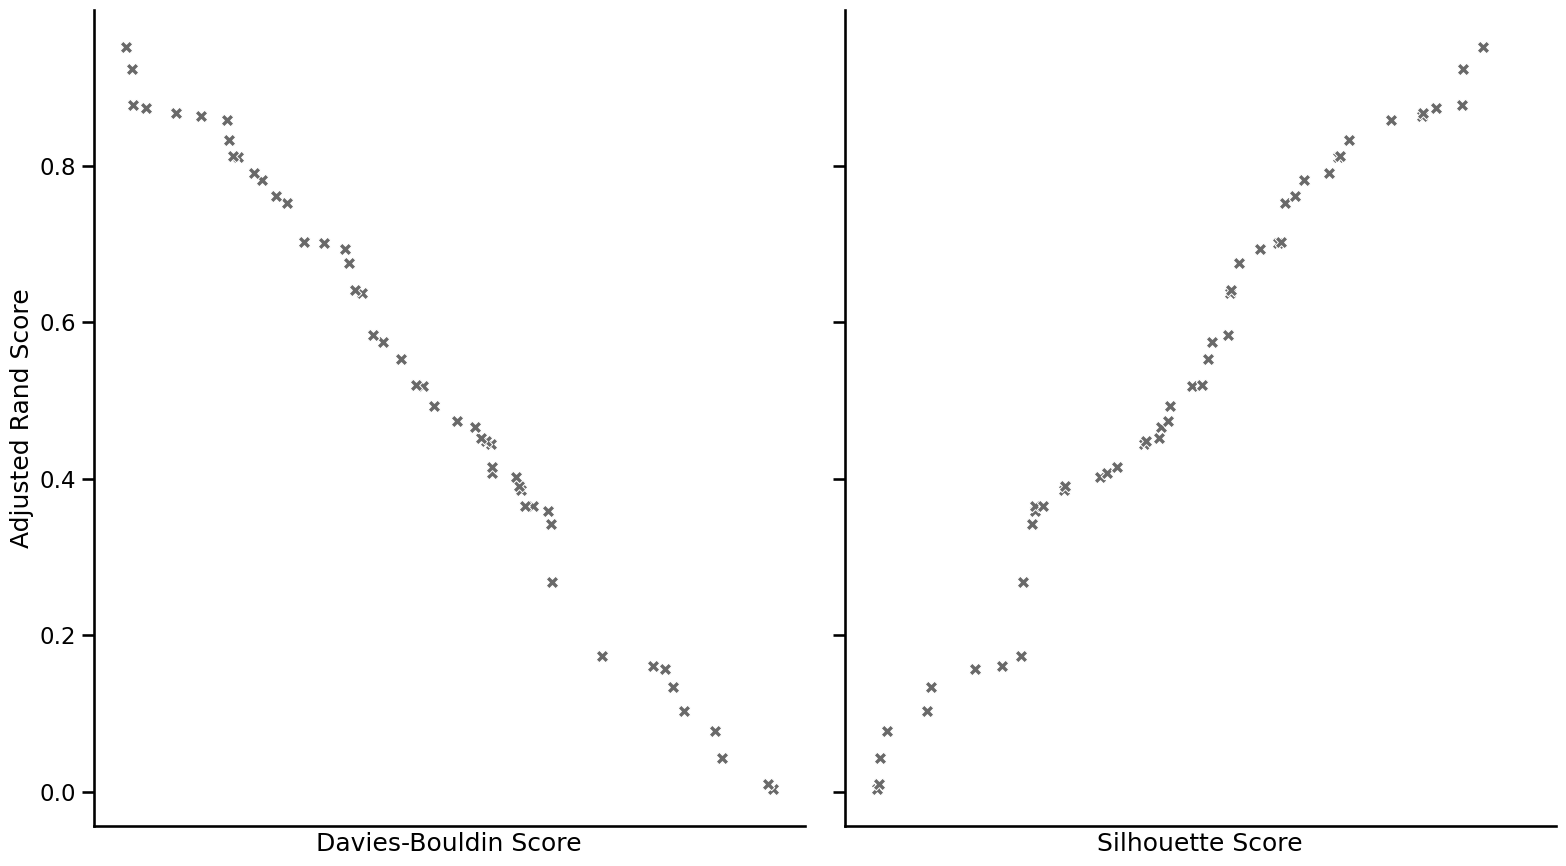

In [ ]:
sns.set_context("talk")
# sweet expectations
fig, axes = plt.subplots(
    1, 2, figsize=(16,9), tight_layout=True, sharey=True, sharex=True
    )

rng = np.random.default_rng(17)
df = pd.DataFrame(
        {
            "Davies-Bouldin Score": sorted(rng.random(50))[::-1],
            "Silhouette Score": sorted(rng.random(50)),
            "Adjusted Rand Score": sorted(rng.random(50))
            }
    )
sns.scatterplot(
    data=df, x="Davies-Bouldin Score", y="Adjusted Rand Score", ax=axes[0],
    color="dimgray", marker="X",
    )
sns.scatterplot(
    data=df, x="Silhouette Score", y="Adjusted Rand Score", ax=axes[1],
    color="dimgray", marker="X",
    )
for ax in fig.axes:
    ax.set_xticks([])
    despine(ax)

In [15]:
def annotate_db_ars(data, color, x_col="Davies-Bouldin Score", y_col="Adjusted Rand Score"):
    """
    Annotates a scatter plot of DB score versus Adjusted Rand Score with a linear regression
    fit, correlation coefficient, and coefficient of determination (R²). Also, it marks the 
    point with the highest ARS ("Max ARS") and the point with the lowest DB score ("Min DB").

    This function is intended to be used with seaborn's FacetGrid.map_dataframe method.
    It expects 'data' to be a DataFrame for a given facet.

    Parameters
    ----------
    data : pandas.DataFrame
        The subset of data for the current facet containing at least the columns specified by 
        `x_col` and `y_col`.
    color : any
        Color information passed by the FacetGrid (not used directly but required by map_dataframe).
    x_col : str, optional
        Column name to use for the x-axis (DB score; lower is better). Default is "Davies-Bouldin Score".
    y_col : str, optional
        Column name to use for the y-axis (Adjusted Rand Score; higher is better). Default is "Adjusted Rand Score".
    """
    # Drop any rows with missing values in the relevant columns
    data = data.dropna(subset=[x_col, y_col])
    x = data[x_col].values
    y = data[y_col].values

    # Ensure data is sorted by x for plotting the regression line
    order = np.argsort(x)
    x_sorted = x[order]
    
    # Compute Pearson's correlation coefficient
    r = np.corrcoef(x, y)[0, 1]
    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x_sorted + intercept
    # Compute R²: 1 - (SS_res / SS_tot)
    ss_res = np.sum((y - (slope * x + intercept)) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    ax = plt.gca()
    # Plot the regression line (sorted by x)
    ax.plot(x_sorted, y_pred, "C1-", label=f"r = {r:.2f}\n$R^2$ = {r2:.2f}")
   # Annotate the point with the highest Adjusted Rand Score
    idx_max_ars = np.argmax(y)
    ax.scatter(x[idx_max_ars], y[idx_max_ars], marker="X", color="red")
    
    if x_col=="Davies-Bouldin Score":
        # Annotate the point with the lowest Davies-Bouldin Score
        stat_xy = (.99, .5)
        idx_min_db = np.argmin(x)
        ax.scatter(x[idx_min_db], y[idx_min_db], marker="X", color="blue")
        ax.annotate("Min DB", xy=(x[idx_min_db], y[idx_min_db]),
                    xytext=(0.05, 0.25), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="->", color="k"), color="k")
        ax.annotate("Max ARS", xy=(x[idx_max_ars], y[idx_max_ars]),
                    xytext=(0.5, 0.4), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="->", color="k"), color="k")
        ax.semilogx()
    else:
        # Annotate the point with the highest Silhouette Score
        stat_xy = (.3, .75)
        idx_min_ss = np.argmax(x)
        ax.scatter(x[idx_min_ss], y[idx_min_ss], marker="X", color="red")
        ax.annotate("Max SS", xy=(x[idx_min_ss], y[idx_min_ss]),
                    xytext=(0.75, 0.25), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="->", color="k"), color="k")
        ax.annotate("Max ARS", xy=(x[idx_max_ars], y[idx_max_ars]),
                    xytext=(0.05, 0.4), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="->", color="k"), color="k")
        ax.set_xlim(-1, 1)

    ax.text(
        *stat_xy, f"$r$ = {r:.2f}\n$R^2$ = {r2:.2f}\nsupport = {len(x)}",
        ha="right", va="center", transform=ax.transAxes)
    ax.set_ylim(-0.19, 1.19)


c:\Users\Semyon\miniconda3\envs\ds\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Semyon\miniconda3\envs\ds\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


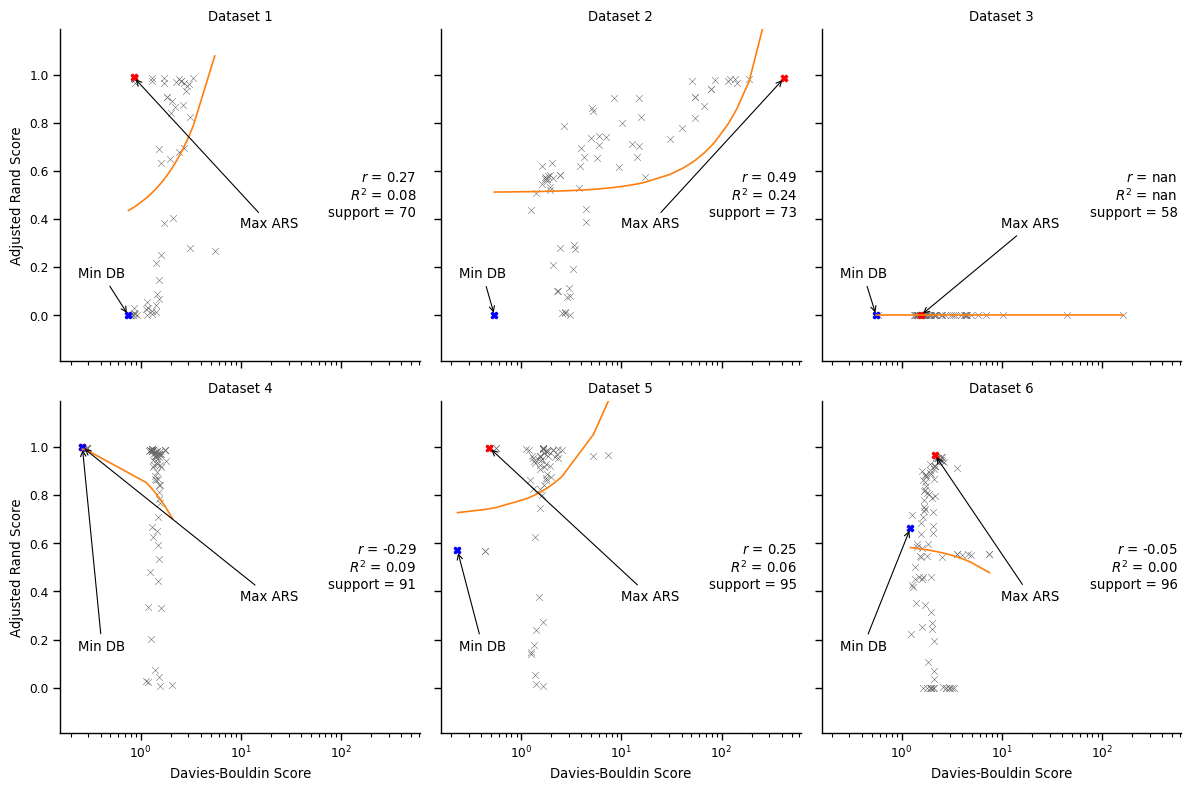

In [16]:
sns.set_context("paper")
g = sns.relplot(
    data=results, x="Davies-Bouldin Score", y="Adjusted Rand Score",
    col="Dataset", col_wrap=3,
    color="dimgray", marker="x",
    height=4,
    )
g.map_dataframe(annotate_db_ars)
g.set_titles("{col_var} {col_name}");
# for ax in g.axes.flat:
#     ax.semilogx()

c:\Users\Semyon\miniconda3\envs\ds\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Semyon\miniconda3\envs\ds\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


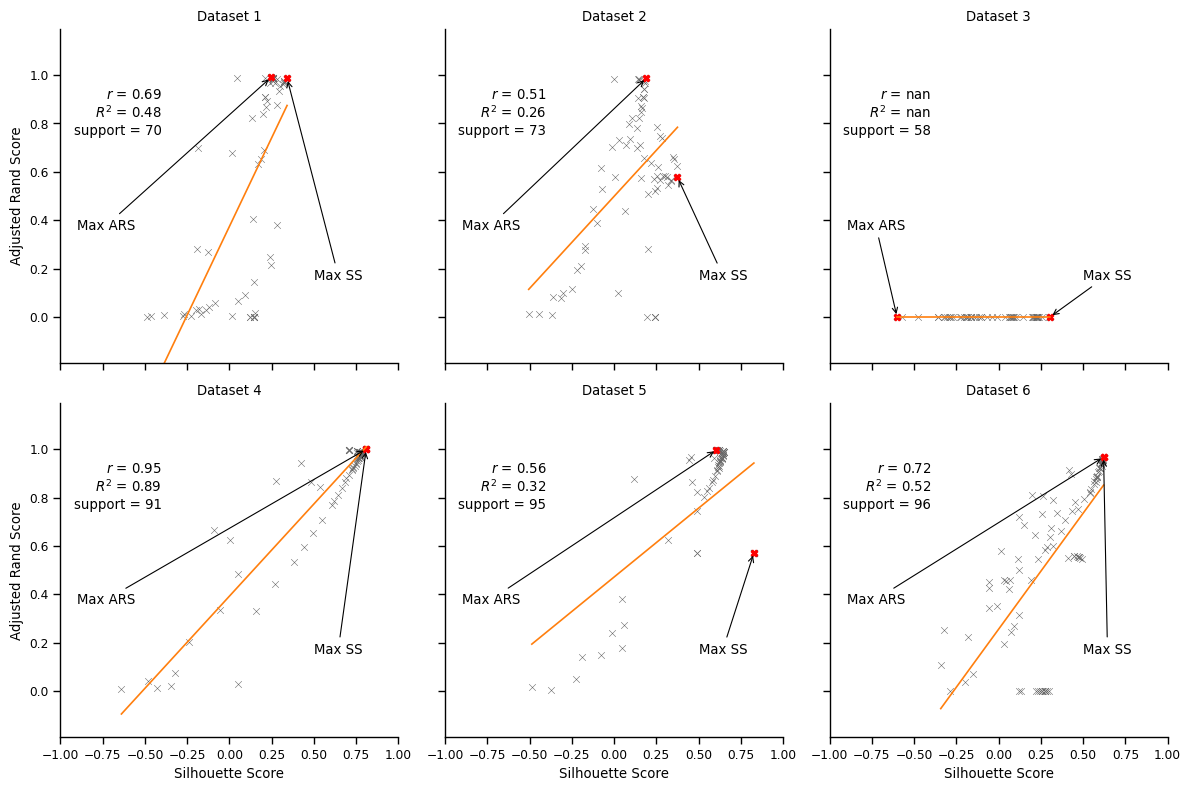

In [17]:
g = sns.relplot(
    data=results, x="Silhouette Score", y="Adjusted Rand Score",
    col="Dataset", col_wrap=3,
    color="dimgray", marker="x",
    height=4,
    )
g.map_dataframe(annotate_db_ars, x_col="Silhouette Score")
g.set_titles("{col_var} {col_name}");